<h2 align='center'><a>Business Problem</h2>


With the rise in the variety of cars with differentiated capabilities and features such as model, production year, category, brand, fuel type, engine volume, mileage, cylinders, color, airbags and many more. We have to predict the car price on the basis of this features and identify the significant features.

Hence we are going to predict for a continuous value and its being a Regression problem.
This is the original problem for Machine Hack by Math Company and we are using statistical approach to check the stability and then move forward to Machine Learning approach

#### <a> Universal Library and Package declaration 

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas_profiling
import missingno as msno
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

#### <a> UDF's 

In [292]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [293]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [294]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [295]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

#### <a> Data Ingestion 

In [296]:
missing_value_formats = ["n.a.","?","NA","n/a", "na", "--","-"]

In [297]:
train = pd.read_csv('train.csv',na_values=missing_value_formats)
test = pd.read_csv('test.csv',na_values=missing_value_formats)

In [298]:
train.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,NaN,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [299]:
test.head()

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,44020629,NaN,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN
1,45784798,NaN,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN
2,45800257,NaN,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN
3,45797981,975.0,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN
4,45814303,NaN,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN


#### <a> Exploratory Data Analysis 

In [300]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              13418 non-null  float64
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [301]:
train.Doors = train.Doors.str.lower()

def replace_name(a,b):
    train.Doors.replace(a,b,inplace=True)

replace_name('04-may','4')
replace_name('02-mar','2')
replace_name('>5','6')

In [302]:
train.apply(lambda x:x.nunique())

ID                  18924
Price                2315
Levy                  558
Manufacturer           65
Model                1590
Prod. year             54
Category               11
Leather interior        2
Fuel type               7
Engine volume         107
Mileage              7687
Cylinders              13
Gear box type           4
Drive wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
dtype: int64

#### <a> Data Type Conversion

In [303]:
train['Mileage'] = pd.to_numeric(train.Mileage.replace('[a-zA-Z]','',regex=True))

#### <i>  Separating Continuous and Categorical Variable 

In [304]:
train_cont = train.loc[:,(train.dtypes == 'float64')|(train.dtypes == 'int64')]
train_cat = train.loc[:,(train.dtypes == 'object')]

In [305]:
train_cont.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
ID,19237.0,0.0,8.767558e+11,4.557654e+07,45772308.0,9.365914e+05,8.772035e+11,20746880.0,42107859.52,44768477.0,45416463.4,45698374.0,45772308.0,45802036.0,45810074.4,45813708.20,45816132.64,4.581665e+07
Price,19237.0,0.0,3.569604e+08,1.855593e+04,13172.0,1.905813e+05,3.632122e+10,1.0,45.00,314.0,627.0,5331.0,13172.0,22075.0,38609.0,49459.00,84675.00,2.630750e+07
Levy,13418.0,5819.0,1.216795e+07,9.068381e+02,781.0,4.618671e+02,2.133212e+05,87.0,308.00,401.7,521.0,640.0,781.0,1058.0,1399.0,1705.45,2410.00,1.171400e+04
Prod. year,19237.0,0.0,3.868393e+07,2.010913e+03,2012.0,5.668673e+00,3.213385e+01,1939.0,1995.00,1999.0,2003.0,2009.0,2012.0,2015.0,2016.0,2017.00,2019.00,2.020000e+03
Mileage,19237.0,0.0,2.947562e+10,1.532236e+06,126000.0,4.840387e+07,2.342935e+15,0.0,0.00,2313.2,25061.4,70139.0,126000.0,188888.0,265210.0,320000.00,571246.84,2.147484e+09
Cylinders,19237.0,0.0,8.816300e+04,4.582991e+00,4.0,1.199933e+00,1.439840e+00,1.0,4.00,4.0,4.0,4.0,4.0,4.0,6.0,8.00,8.00,1.600000e+01
Airbags,19237.0,0.0,1.266300e+05,6.582627e+00,6.0,4.320168e+00,1.866385e+01,0.0,0.00,0.0,0.0,4.0,6.0,12.0,12.0,12.00,12.00,1.600000e+01


* We would be dropping Levy because of high missing values. and also ID column as its of no use.

In [306]:
train_cont.drop(columns=['Levy','ID'],axis = 1,inplace=True)

C:\Users\jagz.000\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [307]:
train_cat.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
Manufacturer,19237,0,HYUNDAI,3769,19.59
Model,19237,0,Prius,1083,5.63
Category,19237,0,Sedan,8736,45.41
Leather interior,19237,0,Yes,13954,72.54
Fuel type,19237,0,Petrol,10150,52.76
Engine volume,19237,0,2,3916,20.36
Gear box type,19237,0,Automatic,13514,70.25
Drive wheels,19237,0,Front,12874,66.92
Doors,19237,0,4,18332,95.3
Wheel,19237,0,Left wheel,17753,92.29


* Clearly for categorical variables we have some outliers that we will cap and there aren't any missing values in the data.

#### <i> Outlier Treatment 

In [308]:
train_cont = train_cont.apply(lambda x:x.clip(lower = x.dropna().quantile(0.01), 
                                                         upper = x.quantile(0.99)))

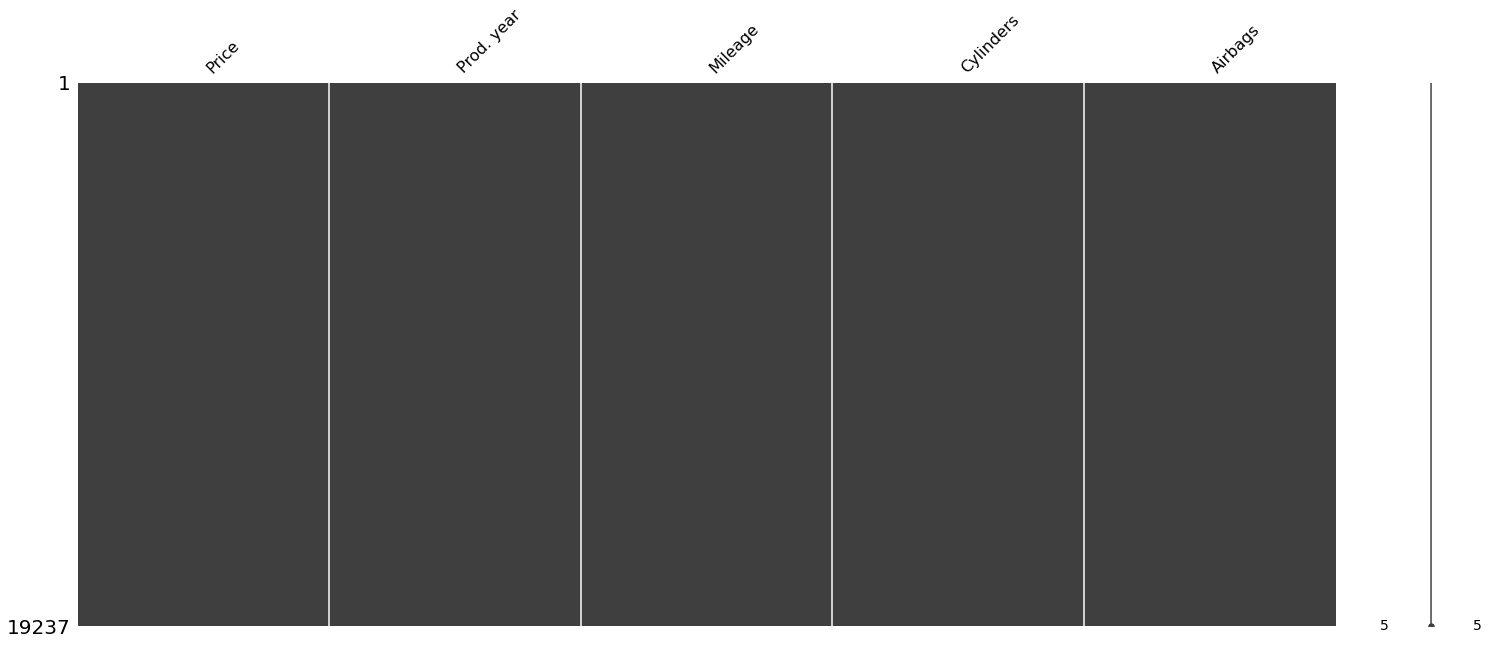

In [309]:
msno.matrix(train_cont)

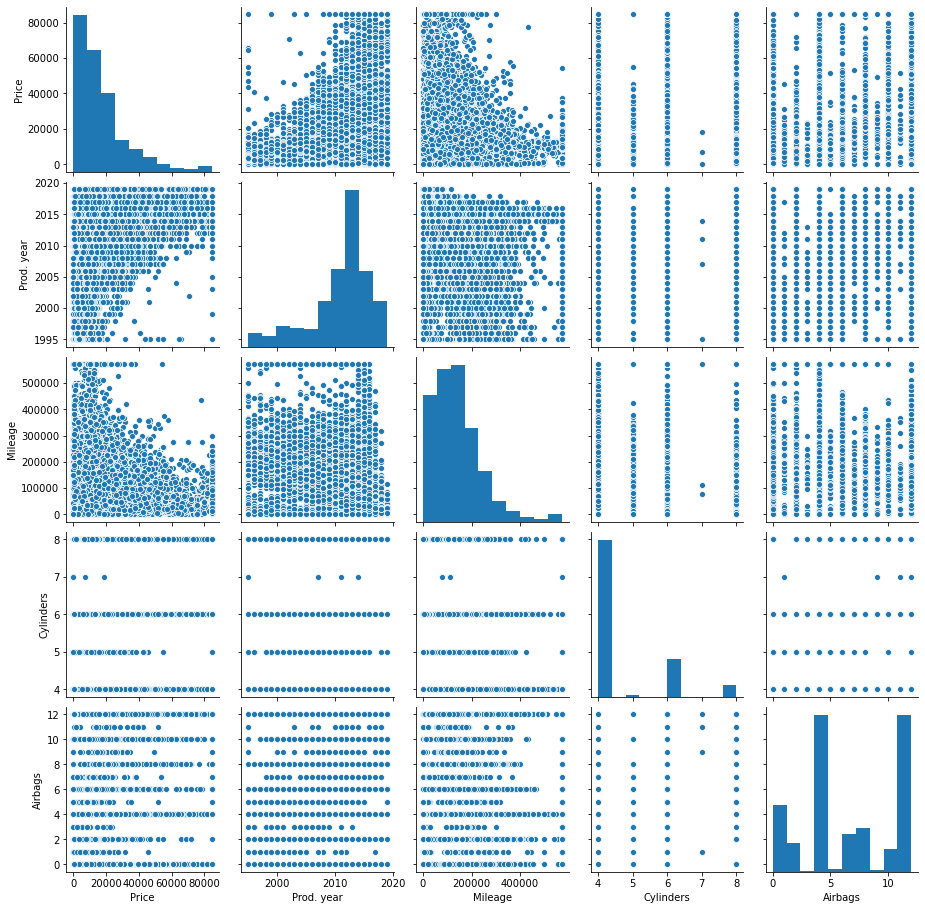

In [206]:
sns.pairplot(train_cont)

In [207]:
report = pandas_profiling.ProfileReport(train)

In [208]:
report.to_file('Report_2.html')

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [310]:
train_cat.drop(columns=[ 'Manufacturer', 'Model','Engine volume'],axis=1,inplace = True)
# high Cardinality

C:\Users\jagz.000\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [311]:
train_cat.apply(lambda x:x.nunique())

Category            11
Leather interior     2
Fuel type            7
Gear box type        4
Drive wheels         3
Doors                3
Wheel                2
Color               16
dtype: int64


#### <i> Handling Categorical Variable

In [312]:
train_cat.head(2)

,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black


In [313]:
train_cat.columns

Index(['Category', 'Leather interior', 'Fuel type', 'Gear box type',
       'Drive wheels', 'Doors', 'Wheel', 'Color'],
      dtype='object')

In [314]:
train_cat = train[[ 'Category', 'Leather interior',
       'Fuel type', 'Gear box type',
       'Drive wheels', 'Doors', 'Wheel', 'Color']]

In [315]:
# for c_feature in categorical_features
for c_feature in train_cat.columns:
    train_cat.loc[:, c_feature] = train_cat[c_feature].astype('category')
    train_cat = create_dummies(train_cat, c_feature)

C:\Users\jagz.000\anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [316]:
final_df = pd.concat([train_cont,train_cat],axis = 1)

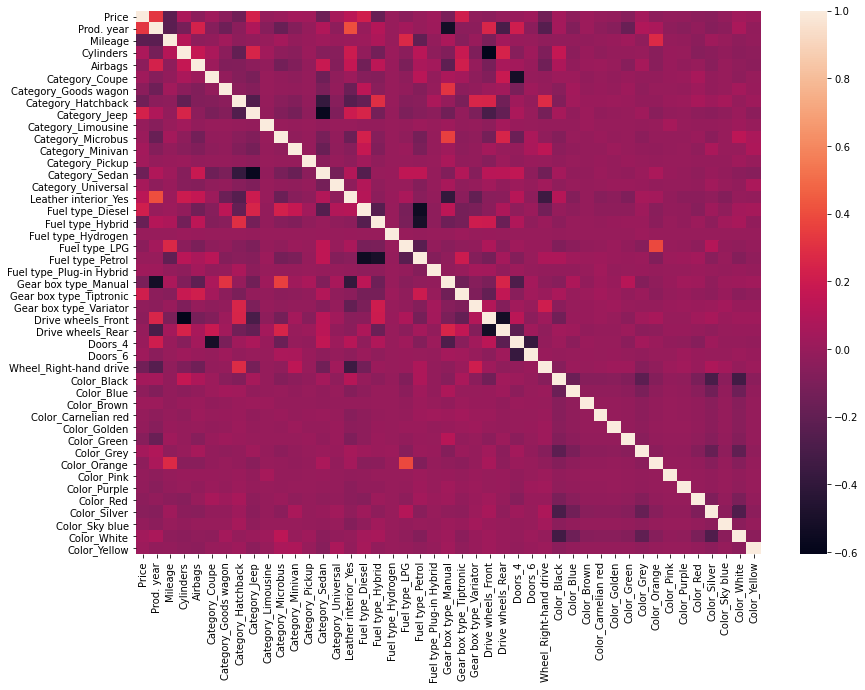

In [317]:
plt.figure(figsize=(14,10))
sns.heatmap(final_df.corr())

In [318]:
final_df.head()

,Price,Prod. year,Mileage,Cylinders,Airbags,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Limousine,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,13328,2010,186005.0,6.0,12,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,16621,2011,192000.0,6.0,8,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,8467,2006,200000.0,4.0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3607,2011,168966.0,4.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,11726,2014,91901.0,4.0,4,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0



#### <i> Normality of Data

1.7308497892226016


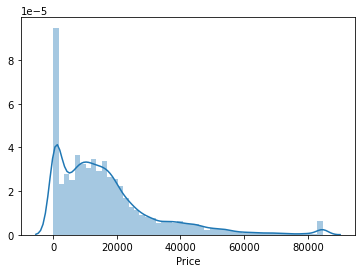

In [319]:
sns.distplot(final_df.Price)
print(final_df.Price.skew())

0.339414948270967

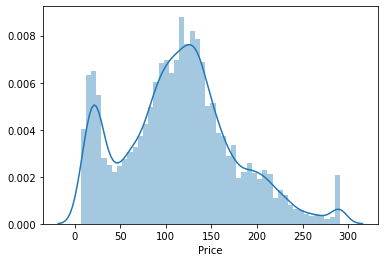

In [320]:
sns.distplot(np.sqrt(final_df.Price))
(np.sqrt(final_df.Price)).skew()

-1.3201912699285272

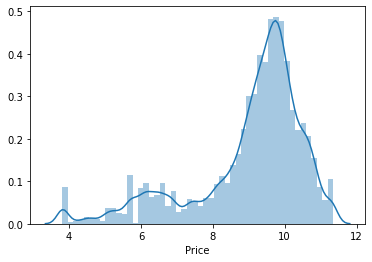

In [321]:
sns.distplot(np.log(final_df.Price))
(np.log(final_df.Price)).skew()

#### Hence we will go for SQRT.

In [322]:
final_df["Price_sqrt"] = np.sqrt(final_df['Price'])

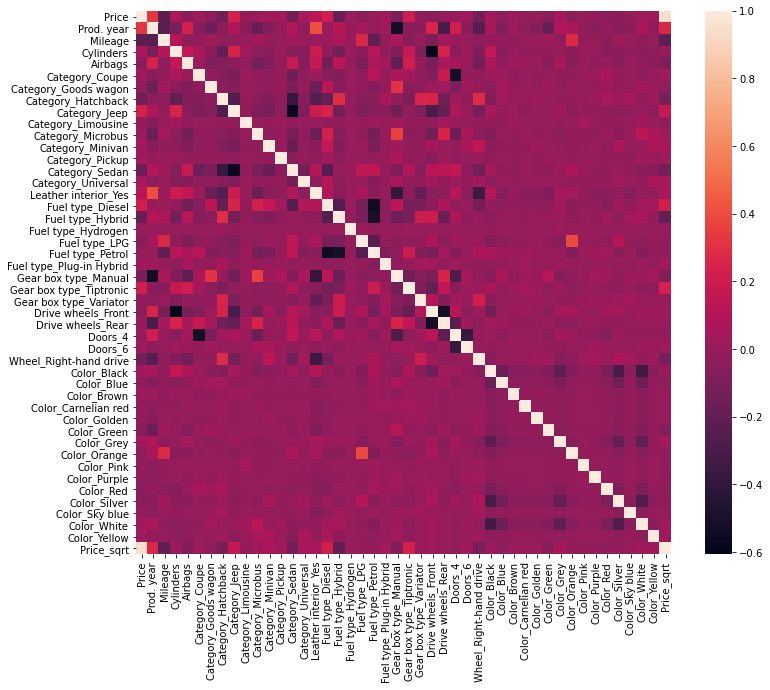

In [323]:
plt.figure(figsize=(12,10))
correlation = final_df.corr()
sns.heatmap(correlation)

In [324]:
final_df.columns

Index(['Price', 'Prod. year', 'Mileage', 'Cylinders', 'Airbags',
       'Category_Coupe', 'Category_Goods wagon', 'Category_Hatchback',
       'Category_Jeep', 'Category_Limousine', 'Category_Microbus',
       'Category_Minivan', 'Category_Pickup', 'Category_Sedan',
       'Category_Universal', 'Leather interior_Yes', 'Fuel type_Diesel',
       'Fuel type_Hybrid', 'Fuel type_Hydrogen', 'Fuel type_LPG',
       'Fuel type_Petrol', 'Fuel type_Plug-in Hybrid', 'Gear box type_Manual',
       'Gear box type_Tiptronic', 'Gear box type_Variator',
       'Drive wheels_Front', 'Drive wheels_Rear', 'Doors_4', 'Doors_6',
       'Wheel_Right-hand drive', 'Color_Black', 'Color_Blue', 'Color_Brown',
       'Color_Carnelian red', 'Color_Golden', 'Color_Green', 'Color_Grey',
       'Color_Orange', 'Color_Pink', 'Color_Purple', 'Color_Red',
       'Color_Silver', 'Color_Sky blue', 'Color_White', 'Color_Yellow',
       'Price_sqrt'],
      dtype='object')

In [325]:
final_df.rename( columns = {'Prod. year' : 'Prod_year','Leather interior_Yes':'Leather_interior_Yes',
                           'Fuel type_Diesel':'Fuel_type_Diesel','Fuel type_Hybrid':'Fuel_type_Hybrid',
                           'Fuel type_Hydrogen':'Fuel_type_Hydrogen','Fuel type_LPG':'Fuel_type_LPG',
                           'Fuel type_Petrol':'Fuel_type_Petrol','Fuel type_Plug-in Hybrid':'Fuel_type_Plug_in_Hybrid',
                           'Gear box type_Manual':'Gear_box_type_Manual','Gear box type_Tiptronic':'Gear_box_type_Tiptronic',
                           'Gear box type_Variator':'Gear_box_type_Variator','Drive wheels_Front': 'Drive_wheels_Front',
                           'Drive wheels_Rear':'Drive_wheels_Rear','Doors_04-May':'Doors_04_May',
                           'Wheel_Right-hand drive':'Wheel_Right_hand_drive','Color_Carnelian red':'Color_Carnelian_red',
                            'Color_Sky blue':'Color_Sky_blue',  'Category_Goods wagon': 'Category_Goods_wagon'}, inplace = True )

#### <a> F-regression


In [349]:
features = train_X
target = train_y
F_values,p_values = f_regression(features,target)

F_reg = pd.DataFrame([feature_columns,F_values,p_values]).T
F_reg.columns = ['Features','F-value','P_value']
Features_f_reg = list(F_reg.loc[F_reg.P_value <=0.05, 'Features'])

In [351]:
print(Features_f_reg)

['Airbags', 'Category_Coupe', 'Category_Goods_wagon', 'Category_Hatchback', 'Category_Jeep', 'Category_Microbus', 'Category_Minivan', 'Category_Pickup', 'Category_Sedan', 'Category_Universal', 'Color_Black', 'Color_Blue', 'Color_Green', 'Color_Grey', 'Color_Pink', 'Color_Red', 'Color_Silver', 'Color_White', 'Color_Yellow', 'Doors_6', 'Drive_wheels_Front', 'Fuel_type_Diesel', 'Fuel_type_Hybrid', 'Fuel_type_Plug_in_Hybrid', 'Gear_box_type_Manual', 'Gear_box_type_Tiptronic', 'Leather_interior_Yes', 'Mileage', 'Prod_year', 'Wheel_Right_hand_drive']


#### <a> VIF 

In [355]:
model_param = formula_m0

In [362]:
y,X = dmatrices(model_param, final_df, return_type='dataframe')
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] =  [variance_inflation_factor(X.values,i) for i in range (X.shape[1])]
vif.round(1)

,Features,VIF
0,Intercept,314930.6
1,Airbags,1.3
2,Category_Coupe,15.4
3,Category_Goods_wagon,7.8
4,Category_Hatchback,71.8
5,Category_Jeep,115.5
6,Category_Limousine,1.3
7,Category_Microbus,9.9
8,Category_Minivan,19.3
9,Category_Pickup,2.5


In [368]:
vif.loc[vif.VIF<4]

,Features,VIF
1,Airbags,1.285387
6,Category_Limousine,1.329498
9,Category_Pickup,2.526409
14,Color_Brown,2.384951
15,Color_Carnelian_red,2.322858
16,Color_Golden,2.070520
17,Color_Green,3.367747
19,Color_Orange,3.127733
20,Color_Pink,1.198601
21,Color_Purple,1.292445


In [370]:
vif_features = list(set(vif.Features).difference(['Intercept']))

#### <a> Model Building

In [327]:
feature_columns = final_df.columns.difference(['Price_sqrt','Price'])

In [328]:
train, test = train_test_split(final_df, test_size= 0.3, random_state= 101)

In [329]:
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  13465  |  No of obs in testing:  5772


In [330]:
train_X, test_X, train_y, test_y = train_test_split(final_df[feature_columns], 
                                            final_df['Price_sqrt'], 
                                                    test_size = 0.3, 
                                                        random_state = 12345)

#### Model - 0 

In [353]:
# model with all features
formula_m0 = 'Price_sqrt~' + '+'.join(feature_columns)

In [283]:
m0 = smf.ols(formula = formula_m0,data=train).fit()

In [284]:
print(m0.summary())

                            OLS Regression Results                            
Dep. Variable:             Price_sqrt   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     144.2
Date:                Sun, 11 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:40:22   Log-Likelihood:                -72044.
No. Observations:               13465   AIC:                         1.442e+05
Df Residuals:                   13421   BIC:                         1.445e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### Model - 1

In [288]:
# model with some restricted features based on m0  summary
formula_m1 = '''Price_sqrt~Airbags+Category_Goods_wagon+Category_Hatchback+
Category_Sedan+Color_Purple+Cylinders+Doors_4+Doors_6+Drive_wheels_Front+Drive_wheels_Rear+
Fuel_type_Diesel+Fuel_type_Hybrid+Fuel_type_Hydrogen+Fuel_type_Petrol+Fuel_type_Plug_in_Hybrid+Gear_box_type_Manual+
Gear_box_type_Tiptronic+Gear_box_type_Variator+Leather_interior_Yes+Mileage+Prod_year+Wheel_Right_hand_drive'''

In [289]:
m1 = smf.ols(formula = formula_m1,data=train).fit()

In [290]:
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:             Price_sqrt   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     292.0
Date:                Sun, 11 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:44:01   Log-Likelihood:                -72070.
No. Observations:               13465   AIC:                         1.442e+05
Df Residuals:                   13443   BIC:                         1.443e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### F-reg and VIF columns 

In [371]:
print(Features_f_reg)

['Airbags', 'Category_Coupe', 'Category_Goods_wagon', 'Category_Hatchback', 'Category_Jeep', 'Category_Microbus', 'Category_Minivan', 'Category_Pickup', 'Category_Sedan', 'Category_Universal', 'Color_Black', 'Color_Blue', 'Color_Green', 'Color_Grey', 'Color_Pink', 'Color_Red', 'Color_Silver', 'Color_White', 'Color_Yellow', 'Doors_6', 'Drive_wheels_Front', 'Fuel_type_Diesel', 'Fuel_type_Hybrid', 'Fuel_type_Plug_in_Hybrid', 'Gear_box_type_Manual', 'Gear_box_type_Tiptronic', 'Leather_interior_Yes', 'Mileage', 'Prod_year', 'Wheel_Right_hand_drive']


In [372]:
print(vif_features)

['Color_Sky_blue', 'Category_Minivan', 'Color_Yellow', 'Fuel_type_Hybrid', 'Color_White', 'Color_Black', 'Drive_wheels_Front', 'Color_Orange', 'Color_Grey', 'Category_Limousine', 'Drive_wheels_Rear', 'Mileage', 'Prod_year', 'Category_Microbus', 'Airbags', 'Category_Goods_wagon', 'Category_Universal', 'Gear_box_type_Manual', 'Color_Pink', 'Color_Green', 'Category_Coupe', 'Fuel_type_Plug_in_Hybrid', 'Color_Red', 'Category_Sedan', 'Cylinders', 'Fuel_type_Petrol', 'Gear_box_type_Tiptronic', 'Doors_6', 'Color_Brown', 'Color_Purple', 'Category_Jeep', 'Wheel_Right_hand_drive', 'Fuel_type_Diesel', 'Color_Blue', 'Category_Hatchback', 'Doors_4', 'Leather_interior_Yes', 'Gear_box_type_Variator', 'Color_Carnelian_red', 'Color_Golden', 'Fuel_type_LPG', 'Color_Silver', 'Fuel_type_Hydrogen', 'Category_Pickup']


In [375]:
formula_m2_f_reg = 'Price_sqrt~' + '+'.join(Features_f_reg)

In [376]:
formula_m3_vif = 'Price_sqrt~' + '+'.join(vif_features)

In [378]:
m2 = smf.ols(formula = formula_m2_f_reg,data=train).fit()

In [377]:
m3 = smf.ols(formula = formula_m3_vif,data=train).fit()

In [379]:
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:             Price_sqrt   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     191.1
Date:                Sun, 11 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:25:40   Log-Likelihood:                -72207.
No. Observations:               13465   AIC:                         1.445e+05
Df Residuals:                   13434   BIC:                         1.447e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [382]:
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:             Price_sqrt   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     144.2
Date:                Sun, 11 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:26:11   Log-Likelihood:                -72044.
No. Observations:               13465   AIC:                         1.442e+05
Df Residuals:                   13421   BIC:                         1.445e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### Statistically unstable R2 is less than .4

In [385]:
# final model based on VIF and F-regression
formula_final = '''Price_sqrt~Airbags+Category_Goods_wagon
+Category_Hatchback+Category_Sedan+Doors_6+Drive_wheels_Front+Fuel_type_Diesel+Fuel_type_Hybrid+
Fuel_type_Plug_in_Hybrid+Gear_box_type_Manual+Gear_box_type_Tiptronic+
Leather_interior_Yes+Mileage+Prod_year+Wheel_Right_hand_drive'''

In [386]:
final_model = smf.ols(formula = formula_final,data=train).fit()

In [387]:
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Price_sqrt   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     378.2
Date:                Sun, 11 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:36:04   Log-Likelihood:                -72231.
No. Observations:               13465   AIC:                         1.445e+05
Df Residuals:                   13449   BIC:                         1.446e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### <a> Validation

In [390]:
train.loc[:, 'Pred_Price'] = np.square(final_model.predict(train))

In [393]:
test.loc[:, 'Pred_Price'] = np.exp(final_model.predict(test))

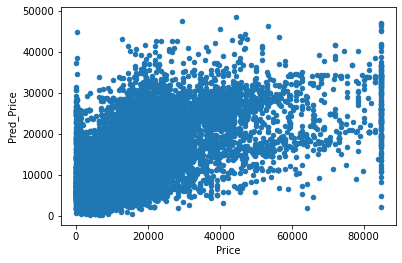

In [395]:
train[['Price', 'Pred_Price']].plot(kind = 'scatter', 
                        x = 'Price', y = 'Pred_Price')
plt.show()

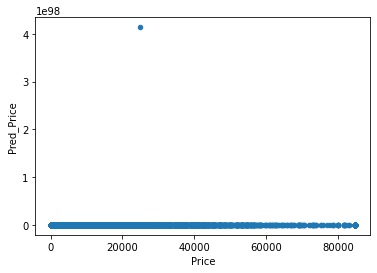

In [396]:
test[['Price', 'Pred_Price']].plot(kind = 'scatter', 
                        x = 'Price', y = 'Pred_Price')
plt.show()

* The relation between Y and Predicted Y can't be justified.

In [397]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train['Price'] - train['Pred_Price'])/train['Price'])
MAPE_test = np.mean(np.abs(test['Price'] - test['Pred_Price'])/test['Price'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  7.338648281367777  |  MAPE of testing data:  2.8940486868251694e+90


In [398]:
# Step 6: accuracy metrics (b. MSE: Mean Squared Error)
MSE_train = mean_squared_error(train.Price, train.Pred_Price)
MSE_test = mean_squared_error(test.Price, test.Pred_Price)

RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

# print the values of MAPE for train and test
print('MSE of training data: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)

# print the values of MAPE for train and test
print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)

MSE of training data:  186563525.96753907  |  MSE of testing data:  2.9666629311335784e+193
RMSE of training data:  13658.825936644009  |  RMSE of testing data:  5.4467081169579655e+96


In [400]:
from sklearn.metrics import mean_absolute_error

In [401]:
# Step 6: accuracy metrics (c. MSE: Mean Absolute Error)
MAE_train = mean_absolute_error(train.Price, train.Pred_Price)
MAE_test = mean_absolute_error(test.Price, test.Pred_Price)

# print the values of MAPE for train and test
print('MAE of training data: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data:  9266.568522347074  |  MAE of testing data:  7.169551142039962e+94


In [404]:

train['Deciles'] = pd.qcut(train['Pred_Price'], 10, labels = False)
test['Deciles'] = pd.qcut(test['Pred_Price'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'Pred_Price']].groupby(train.Deciles).mean().sort_index(ascending = False)['Pred_Price']
Actual_avg = train[['Deciles', 'Price']].groupby(train.Deciles).mean().sort_index(ascending = False)['Price']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'Pred_Price']].groupby(test.Deciles).mean().sort_index(ascending = False)['Pred_Price']
Actual_avg = test[['Deciles', 'Price']].groupby(test.Deciles).mean().sort_index(ascending = False)['Price']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# write the data into the file
Decile_analysis_train.to_csv('Decile_analysis_train.csv')
Decile_analysis_test.to_csv('Decile_analysis_test.csv')

<ipython-input-404-900554d51cfa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Deciles'] = pd.qcut(train['Pred_Price'], 10, labels = False)
<ipython-input-404-900554d51cfa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Deciles'] = pd.qcut(test['Pred_Price'], 10, labels = False)


In [405]:
Decile_analysis_train

,Deciles,Pred_Price,Price
0,9,30058.329440,37854.867854
1,8,23579.799874,26408.254829
2,7,19631.279611,21745.185598
3,6,16159.627292,19861.776952
4,5,13520.773256,14493.734967
5,4,11507.806781,12683.662955
6,3,9811.799606,10449.896654
7,2,8118.598752,9968.077893
8,1,6125.036936,8658.695394
9,0,3673.221544,6787.988122


In [406]:
Decile_analysis_test

,Deciles,Pred_Price,Price
0,9,7.159628e+95,36989.615917
1,8,6.595294e+67,25786.847487
2,7,3.818836e+61,22337.609375
3,6,1.003036e+56,19281.034602
4,5,1.362879e+51,14027.816291
5,4,9.755518e+46,12051.700173
6,3,2.238953e+43,10117.428076
7,2,6.520016e+39,9344.490468
8,1,3.187756e+35,9078.515734
9,0,4.580437e+29,6599.090909


# Decile Analysis on test is not justified